# Training a regression with two outputs and Custom Loss Function

Use pytorch to take into account the correlation during the training

## Settings

In [1]:
n_variables = 4 # Number of data and background varialbes to generate
n_samples = 10000 # Number of samples to generate

center_signal = 2.0 # Where the gaussian for signal should be
center_background = 1.0 # Where the gaussian for background should be

In [2]:
import sys
sys.path += ['../abcdlib']
import data_gen

import seaborn as sns
import pandas as pd
from torch import nn
from torch import optim
import torch
import numpy as np

## Generate the data

In [3]:
sig = data_gen.generate_gaussian(n_variables, center_signal, n_samples)
back = data_gen.generate_gaussian(n_variables, center_background, n_samples)

half = int(n_samples/2)

training = data_gen.combine(sig[:half], back[:half])
testing = data_gen.combine(sig[half:], back[half:])

## Train with two outputs and a custom loss function

For a regression, we need just a single output column with the 1 or 0 as the target value. Of course, this time we need 2 columns, duplicated.

In [4]:
label = training[training.columns[-1]].values
labels = np.stack((label, label), axis=1)

In [5]:
x_train = torch.Tensor(training[training.columns[:-1]].values)
y_train = torch.Tensor(labels)

The loss function should be a combination of the normal accuracy loss function and also the correlation on background (only):

- Use the accuracy on all the training data
- Calculate the correlation only on items marked as being background

In [6]:
def calc_r(prediction):
    mean = torch.mean(prediction, dim=0)
    std_dev = torch.std(prediction, dim=0)
    parts = (prediction - mean)
    sum = torch.sum(parts[:,0]*parts[:,1])
    return sum / std_dev[0] / std_dev[1] / (prediction.shape[0]-1)

class decorrelate_loss:
    '''Calculate the loss function using MSELoss and decorrelation loss
    '''
    def __init__(self):
        self._mse = nn.MSELoss(reduction='mean')
        
    def __call__(self, prediction, labels):
        'Calc the loss given both the correlation and mse'
        mse_loss = self._mse(prediction, labels)
        
        background_mask = labels[:,1] == 0
        r = calc_r(prediction[background_mask])

        total = mse_loss + torch.square(r)*1000.0
        return total

Next create a simple classifier - 2 layers, with the same number of nodes as inputs. It looks like doubling the size of the inputs and outputs makes a big difference, but in general getting this to train better hasn't been successful so far. No idea why.

In [7]:
model = nn.Sequential(nn.Linear(n_variables, n_variables*2),
                      nn.ReLU(),
                      nn.Linear(n_variables*2, n_variables*2),
                      nn.ReLU(),
                      nn.Linear(n_variables*2, n_variables*2),
                      nn.ReLU(),
                      nn.Linear(n_variables*2, n_variables),
                      nn.ReLU(),
                      nn.Linear(n_variables, 2))
criterion = decorrelate_loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Now lets do the training

In [28]:
%%time
epochs = 20000
for e in range(epochs):
    running_loss = 0
    optimizer.zero_grad()
    output = model(x_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if e % 300 == 0:
        print(f'Training loss ({e}): {running_loss/len(x_train)}')
else:
    print(f'Training loss: {running_loss/len(x_train)}')

Training loss (0): 1.492636352777481e-05
Training loss (300): 1.5845219790935518e-05
Training loss (600): 1.4792999625205994e-05
Training loss (900): 1.4700908958911895e-05
Training loss (1200): 1.4635497331619263e-05
Training loss (1500): 1.4577606320381165e-05
Training loss (1800): 1.4524272084236145e-05
Training loss (2100): 1.7329804599285126e-05
Training loss (2400): 1.4447736740112304e-05
Training loss (2700): 1.440475732088089e-05
Training loss (3000): 1.4371535181999207e-05
Training loss (3300): 1.4340654015541077e-05
Training loss (3600): 1.4311912655830383e-05
Training loss (3900): 1.461867094039917e-05
Training loss (4200): 1.4632719755172729e-05
Training loss (4500): 1.4269956946372985e-05
Training loss (4800): 1.4227452874183654e-05
Training loss (5100): 1.4208899438381195e-05
Training loss (5400): 1.4192520081996918e-05
Training loss (5700): 1.4183656871318817e-05
Training loss (6000): 1.4353568851947785e-05
Training loss (6300): 1.4158907532691956e-05
Training loss (6600

## Prediction

Get the predicted probabilities out and see where they line up and how well this guy did!

In [29]:
x_test = torch.Tensor(testing[testing.columns[:-1]].values)
y_test = model(x_test)

In [30]:
x_results = testing.copy()
x_results['Prediction_1'] = y_test.detach().numpy()[:,0]
x_results['Prediction_2'] = y_test.detach().numpy()[:,1]

<AxesSubplot:xlabel='Prediction_1', ylabel='Count'>

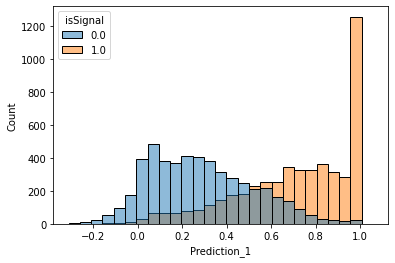

In [31]:
sns.histplot(x_results, x='Prediction_1', hue='isSignal')

<AxesSubplot:xlabel='Prediction_2', ylabel='Count'>

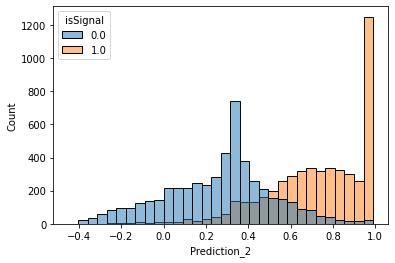

In [32]:
sns.histplot(x_results, x='Prediction_2', hue='isSignal')

Lets look at the correlation between these on background and signal data

<AxesSubplot:xlabel='Prediction_1', ylabel='Prediction_2'>

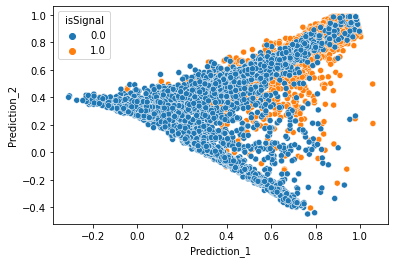

In [33]:
sns.scatterplot(data=x_results, x='Prediction_1', y='Prediction_2', hue='isSignal')

Other than something odd going on down near zero, this looks very correlated for background (and signal). We need the background to be uncorrelated...

## Correlation for the background

Lets see what the final number of the correlation is of the background

In [34]:
label = torch.Tensor(testing[testing.columns[-1]].values)
mask = label == 0.0
calc_r(y_test[mask])

tensor(-0.0302, grad_fn=<DivBackward0>)

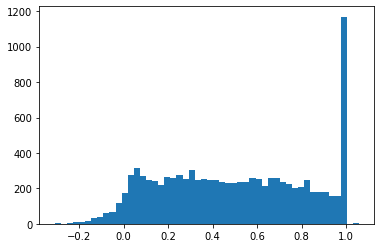

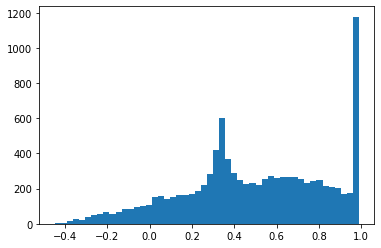

In [35]:
import matplotlib.pyplot as plt
plt.hist(y_test[:,0].detach().numpy(), bins=50)
plt.show()
_ = plt.hist(y_test[:,1].detach().numpy(), bins=50)

Test the JB test on a known normal distribution

In [36]:
normal = torch.normal(1.0, 1.0, (10000,))

## Write the data out for use by others when testing various de-correlation tests.

In [37]:
np.save('../data/05-uncorrelated', y_test[mask].detach().numpy())